In [ ]:
#Logan Kelsch + JJ
'''
/*
 *  taking this version of neural network training takes only a few features
 *          [ high, low, open, close, volume, TimeOfDay, DayOfWeek ]
 *  and uses common techniques described in 'features_creation.py' to largely
 *  expand dimensionality. 
 *  As of writing this (11/24/24) there is limited expansion
*/
''' 

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
#from imblearn.over_sampling import SMOTE
from funcs_data_preprocess import *
from feature_creation import *
from tensorflow.keras.optimizers import AdamW


# Load the dataset
data = pd.read_csv('betaset_tmp.csv')

'''#---------------#
    MODEL VARIABLES
'''#---------------#


indp_size       = 0.1       #size of indepentendent set of samples
test_size       = 0.2       #size of validation set of samples
num_isol_feats  = 0         #number of features to be left out of PCA transformation
                            #   this function is depricated/needs updated
use_PCA         = True      #bool for use of PCA feature decomp. and transformation
comps_PCA       = 86        #number of primary components to use under PCA t.
time_steps      = 20        #LSTM time steps used
t_start         = 570       #start time for time based sample filtering
t_end           = 645       #end   time for time based sample filtering

params = model_params()
params = get_model_params(
    m_type          = 'Regression'      # {'Regression', 'Classification'}

   ,r_target        = 15        #[target's minutes in future] if the model is regression
   ,c_split_val     = 2
   ,c_class_cnt     = 5
)


#drop unused target columns
data = data.drop(columns=[f't_{i}' for i in range(1,params.r_target_min)])
data = data.drop(columns=[f't_{i}' for i in range(params.r_target_min+1,61)])

#collect all sample indices to be kept through time filter
#two seperate functions to keep main and ind test isolated
keep_ndx = grab_wanted_times(data.values, t_start, t_end, time_steps)

data = data.drop(columns=return_name_collection())
#data = data.drop(columns=fn_orig_price())
data = data.drop(columns=fn_orig_time())


#confirmation printout of all features/targets
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)


# Separate features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

y = y_preprocess(params, y)

X_nrm = normalize_from_tt_split(X, X, test_size)
if(use_PCA):
    X = reform_with_PCA_isolated(X_nrm, X_nrm, test_size, num_isol_feats, comps_PCA)
X, y = reformat_to_lstm(X, y, time_steps)

print('\nX shape == {}.'.format(X.shape))
print('y shape == {}.\n'.format(y.shape))


print(f'Raw Sample Count:\t{len(X)}')
X,     y     = filter_times(X,     y,     keep_ndx)
print(f'Remaining Sample Count:\t{len(X)}')

#split all samples 3 ways into training, and testing
#   and split all testing into validation and independent
X_train, X_val, X_ind, y_train, y_val, y_ind =\
    split_into_train_val_ind(X, y, test_size, indp_size, time_steps)


print('\nX_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('X_val shape == {}.'.format(X_val.shape))
print('y_val shape == {}.'.format(y_val.shape))
print('X_ind shape == {}.'.format(X_ind.shape))
print('y_ind shape == {}.\n'.format(y_ind.shape))


#LEARNING RATES____________________________________________________________________________________________
from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    #good rough val to start, .25, good val to end at .0015.
    #5k epoch should be: .25, 8565, .9995, true
    0.01,
    decay_steps=100,
    decay_rate=0.997,
    staircase=True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.75, 
    patience=12, 
    min_lr=1e-8
)

opt1 = SGD(learning_rate=0.0001)
opt2  = tf.keras.optimizers.Adam(learning_rate=0.001)
opt3 = SGD(learning_rate=lr_schedule)
opt4 = SGD(learning_rate=0.001, momentum=0.7)
opt5 = tf.keras.optimizers.Adam(learning_rate=0.0005)
opt6 = AdamW(learning_rate=0.00055, weight_decay=0.00)

#BUILD AND LOAD MODEL__________________________________________________________________________________________


#print(X_train.shape[0]/time_steps)
#X_train = np.reshape(X_train,((X_train.shape[0]//time_steps), time_steps, 35))  # Reshape to (batch_size, 5 time steps, 35 features)
#y_train = y.reshape(1,-1)
from tensorflow.keras import regularizers

def build_LSTM_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(X_train.shape[1],X_train.shape[2])),
        tf.keras.layers.LSTM(8, activation='tanh', recurrent_dropout=0.0, return_sequences=True),#, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.LSTM(8, activation='tanh', recurrent_dropout=0.0, return_sequences=True),#, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        tf.keras.layers.LSTM(8, activation='tanh', recurrent_dropout=0.0, return_sequences=False),#, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Dense(16),# kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.BatchNormalization(),
        #tf.keras.layers.Activation('relu'),
        #tf.keras.layers.Dropout(0.0),
        tf.keras.layers.Dense(params.target_neurons, activation=params.target_activation)
    ])
    model.compile(optimizer=opt6,
                  loss=params.loss_function
                  ,metrics=params.performance_metrics)
    return model
'''
def load_model():
    loaded_model = tf.keras.models.load_model('r30_10s_LSTM_8.keras')
    loaded_model.compile(optimizer=opt4,
                         loss='mse'
                         , metrics=['R2Score','root_mean_squared_error'])
    return loaded_model
'''
#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 150

early_stopping = EarlyStopping(monitor='val_loss', patience=15, mode='min', restore_best_weights=True)

cmp = 'C'
if tf.config.list_physical_devices('GPU'):
    cmp = 'G'
    pass
with tf.device('/'+cmp+'PU:0'):
    print('Running on: '+cmp+'PU\n')
    model = build_LSTM_model()
    #loaded_model = load_model()
    used_model = model
    history = used_model.fit(X_train, y_train, epochs=epochs,\
                        shuffle=False, verbose=1, validation_data=(X_val, y_val),\
                        batch_size=480,callbacks=[reduce_lr, early_stopping])

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

#show_all_results(used_model, history, X_test, y_test)

# LOSS
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs[1:], history.history['loss'][1:], 'y', label='Training Loss')
plt.plot(epochs[1:], history.history['val_loss'][1:], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# R2SCORE

plt.plot(epochs[1:], history.history['R2Score'][1:], 'y', label='Training R2')
plt.plot(epochs[1:], history.history['val_R2Score'][1:], 'r', label='Validation R2')
plt.title('Training and Validation R2Score')
plt.xlabel('Epoch')
plt.ylabel('R2Score')
plt.ylim(bottom=0)
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


#predicting the test set results
y_pred, y_val = model_predict(used_model, params, X_val, y_val)

plt.scatter(y_pred, y_val, s=1)
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-25,25)
plt.ylim(-25,25)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

#SCATTERPLOT #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  
plt.scatter(y_pred, y_val, s=1)
plt.grid()
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

used_model.save('tmp.keras')

In [7]:
used_model.save('r30_PCA10_6.keras')

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


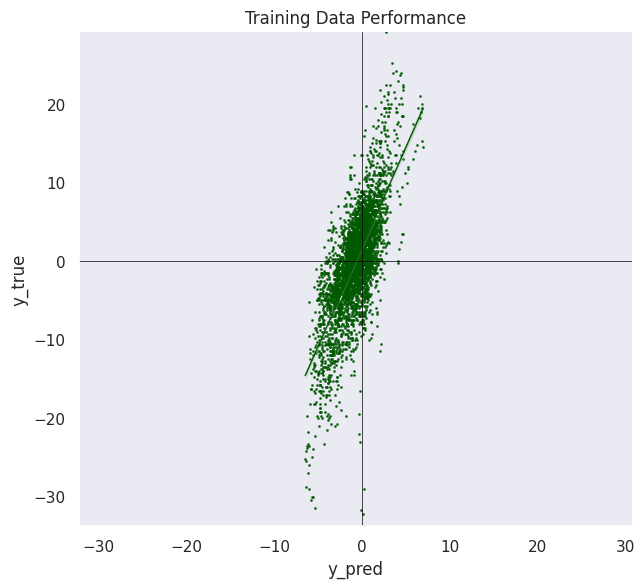

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


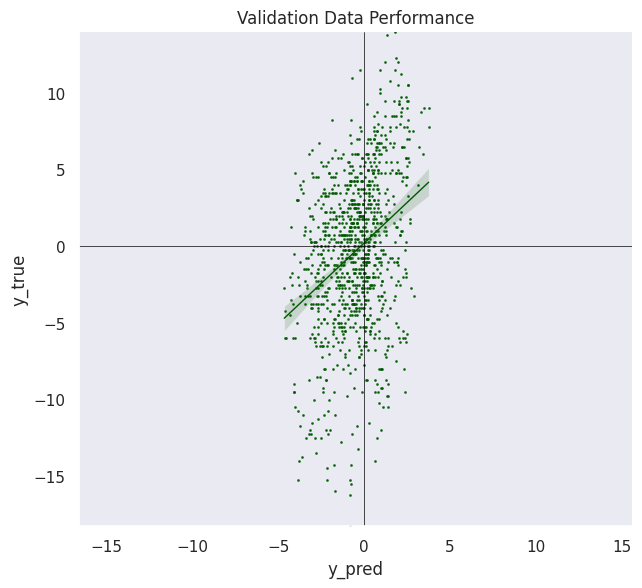

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


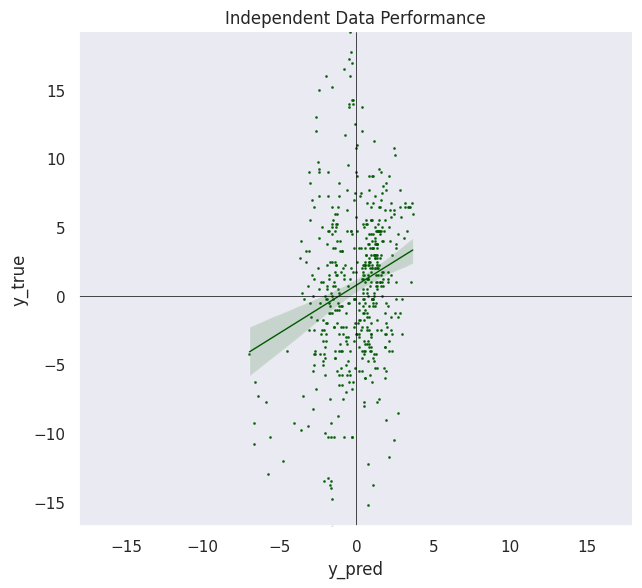

In [2]:
#new_model = tf.keras.models.load_model("r30_PCA10_1.keras")

'''
plt.figure(figsize=(7, 6))
#SCATTERPLOT #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  #SCATTERPLOT  
plt.scatter(y_pred, y_exam, s=1)
plt.grid()
plt.axis('tight')
plt.title('Testing Outputs')
plt.xlabel('y_pred')
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.ylabel('y_test')
ax = plt.gca()
x_vals = np.array(ax.get_xlim())
y_vals = x_vals  # Since y = x
plt.plot(x_vals, y_vals, '-', color='black', label='y = x', linewidth=0.5)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()
'''
s_kws = {'s':1,'color':(0,.35,0)}
l_kws = {'lw':1,'color':(0,.35,0)}

import seaborn as sns

#Training set
y_pred = used_model.predict(X_train) 
#sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme()
y_pred = np.squeeze(y_pred)
y = np.squeeze(y)
ys = pd.DataFrame({"y_pred":y_pred,"y_true":y_train})
g = sns.lmplot(data=ys,x="y_pred", y="y_true", scatter_kws=s_kws, line_kws=l_kws)#,hue="MO")
g.fig.set_size_inches(7,6)
plt.title('Training Data Performance')
plt.grid()
y_min, y_max = ys['y_true'].min(), ys['y_true'].max()
plt.ylim(y_min, y_max)
x_center = np.mean(ys['y_pred'])
y_range = y_max - y_min
x_min = x_center - y_range / 2
x_max = x_center + y_range / 2
plt.xlim(x_min, x_max)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

#Validation set
y_pred = used_model.predict(X_val) 
#sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme()
y_pred = np.squeeze(y_pred)
y = np.squeeze(y)
ys = pd.DataFrame({"y_pred":y_pred,"y_true":y_val})
g = sns.lmplot(data=ys,x="y_pred", y="y_true", scatter_kws=s_kws, line_kws=l_kws)#,hue="MO")
g.fig.set_size_inches(7,6)
plt.title('Validation Data Performance')
plt.grid()
y_min, y_max = ys['y_true'].min(), ys['y_true'].max()
plt.ylim(y_min, y_max)
x_center = np.mean(ys['y_pred'])
y_range = y_max - y_min
x_min = x_center - y_range / 2
x_max = x_center + y_range / 2
plt.xlim(x_min, x_max)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()


#independant data performance
y_pred = used_model.predict(X_ind) 
#sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
sns.set_theme()
y_pred = np.squeeze(y_pred)
y = np.squeeze(y)
ys = pd.DataFrame({"y_pred":y_pred,"y_true":y_ind})
g = sns.lmplot(data=ys,x="y_pred", y="y_true", scatter_kws=s_kws, line_kws=l_kws)#,hue="MO")
g.fig.set_size_inches(7,6)
plt.title('Independent Data Performance')
plt.grid()
y_min, y_max = ys['y_true'].min(), ys['y_true'].max()
plt.ylim(y_min, y_max)
x_center = np.mean(ys['y_pred'])
y_range = y_max - y_min
x_min = x_center - y_range / 2
x_max = x_center + y_range / 2
plt.xlim(x_min, x_max)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0,color='black',linewidth=0.5)
plt.show()

In [ ]:
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs[1:], history.history['loss'][1:], 'y', label='Training Loss')
plt.plot(epochs[1:], history.history['val_loss'][1:], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()